In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from tqdm import tqdm
import random
from sklearn.decomposition import PCA
from data_augmentation import build_balanced_augmented_tensor_dataset  # calcoliamo l'exlained variance sui dati augmentati

In [2]:
# CONFIGURAZIONE
data_dir = 'data_histo'  # cambia percorso se necessario
image_size = 224  # più piccolo per velocizzare il test
batch_size = 11000 # batch size provati : 32, 800, 2048
train_ratio, val_ratio = 0.7, 0.15

In [3]:
# TRASFORMAZIONE IMMAGINI
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [4]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size
print(train_size)

10497


In [5]:
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size],
                                            generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 
# droplast = True per scartare il batch non completo di 32 immagini, in questo calso è false, quindi non viene scartato

In [6]:
# ESTRAZIONE E FLATTENING IMMAGINI
def extract_data(loader):
    data = []
    for images, _ in tqdm(loader, desc="Caricamento immagini"): # prende il batch del data loader
        flat = images.view(images.size(0), -1)  # flatten [B, C, H, W] → [B, C*H*W]
        data.append(flat) #collezione dei dati del batch appiattiti
    data = torch.cat(data, dim=0) # concatena tutti i batch delle immagini
    return data.numpy()

train_data = extract_data(train_loader)

Caricamento immagini:   0%|          | 0/1 [00:34<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler

print("\nCalcolo normalizzazione globale con StandardScaler (z-score)...")
scaler = StandardScaler()

for images, _ in tqdm(train_loader, desc="Fit scaler"):
    flat = images.view(images.size(0), -1).numpy().astype(np.float32)
    scaler.partial_fit(flat)

train_data_std = scaler.transform(train_data)


Calcolo normalizzazione globale...


Calcolo min/max globali: 100%|██████████| 1/1 [01:55<00:00, 115.47s/it]


In [ ]:

# PCA
pca = PCA()
pca.fit(train_data_std)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

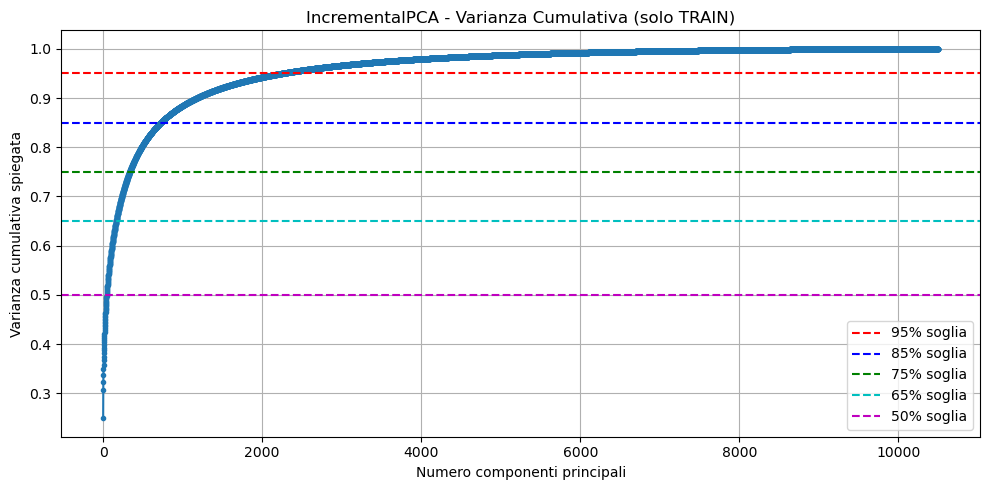

In [ ]:
# GRAFICO VARIANZA CUMULATIVA
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='.')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.axhline(y=0.85, color='b', linestyle='--', label='85% threshold')
plt.axhline(y=0.75, color='g', linestyle='--', label='75% threshold')
plt.axhline(y=0.65, color='c', linestyle='--', label='65% threshold')
plt.axhline(y=0.50, color='m', linestyle='--', label='50% threshold')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.title('PCA, explained variance for histological images')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

è molto strano che le componenti totali siano poco più di 30, quando abbiamo tante immagini (14.996) a colori e 224 x 224 
eseguiamo una serie di test per vedere se tutto funziona correttmente (cella 12) e vedere come comportarci successivamente

In [ ]:
# STAMPA NUM COMPONENTI PER SOGLIA
soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
for soglia in soglie:
    num_components = np.argmax(cumulative_variance >= soglia) + 1
    print(f"Number of components that explains {int(soglia*100)}% of variance: {num_components}")

Componenti che spiegano almeno il 95% della varianza: 2252
Componenti che spiegano almeno il 85% della varianza: 725
Componenti che spiegano almeno il 75% della varianza: 336
Componenti che spiegano almeno il 65% della varianza: 165
Componenti che spiegano almeno il 50% della varianza: 46
